In [1]:
%matplotlib inline
import astropy.io.fits as pyfits
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import subprocess as sp
import scipy.ndimage as sci_nd
import glob
import matplotlib.pyplot as mpl
from astropy.table import Table
import sys
import os
from astropy.io import ascii


In [2]:
#from utils on Bruno's github

def select_object_map(xc,yc,segmap,pixscale,radius):
    r"""Filters the segmentation mask of the object by setting all regions
    outside the given radius (in arcseconds) to 0 in the output segmentation
    mask.
    Parameters
    ----------
    xc : float
        the horizontal coordinate (in pixel) of the object center
    yc : float
        the vertical coordinate (in pixel) of the object center
    segmap: int, array
        A binary image array flagging all pixels to be considered for the
        computation. It uses all pixels with non-zero values.
    pixscale : float
        The scale to convert between pixel and arcseconds (given in arcsec/pix).
        If one wants to compute everything in pixel coordinates simply set the
        pixscale to one.
    radius : float
        The distance to consider above which all detected objects are discarded.
        Note that it is only required that a region has at least one pixel at a
        distance smaller than radius to be included in the filtered segmentation
        mask.
    Returns
    -------
    new_map : int, array
        A binary array with all regions containing at least one pixel at a
        distance smaller than the given radius.
    References
    ----------
    Examples
    --------
    """
    Dmat,d=distance_matrix(xc,yc,segmap)
    s_values = np.unique(segmap[Dmat<np.sqrt(2)*radius/pixscale])
    new_map = segmap.copy()
    for s in s_values:
        if s==0:
            continue
        new_map[new_map==s]=-1
    new_map[new_map>0]=0
    return -new_map

def select_object_map_connected(xc,yc,image,segmap,pixscale,radius=0.5):
    r"""Selects a single connected region on the segmentation mask that contains
    the brightest pixel inside the given radius (in arcseconds).
    Parameters
    ----------
    xc : float
        the horizontal coordinate (in pixel) of the object center
    yc : float
        the vertical coordinate (in pixel) of the object center
    img : float, array
        The image array containing the data for which to select the region.
    segmap: int, array
        A binary image array flagging all pixels to be considered for the
        computation. It uses all pixels with non-zero values.
    pixscale : float
        The scale to convert between pixel and arcseconds (given in arcsec/pix).
        If one wants to compute everything in pixel coordinates simply set the
        pixscale to one.
    radius : float
        The distance to consider above which all detected objects are discarded.
        Note that it is only required that a region has at least one pixel at a
        distance smaller than radius to be included in the filtered segmentation
        mask.
    Returns
    -------
    new_map : int, array
        A binary array with the connected region containing the brightest pixel
        at a distance smaller than the given radius.
    References
    ----------
    Examples
    --------
    """
    Regions,Nregions = sci_nd.label(segmap)
#    A= np.array([np.size(Regions[Regions==n]) for n in range(1,Nregions+1)])
    try:
        central_region = image.copy()
        #print('test1')
        Dmat,d=distance_matrix(xc,yc,segmap)
        #print('test2')
        ##print('Dmat shape:',np.shape(Dmat),'lenght Dmat:',len(Dmat),'type Dmat:', type(Dmat))#,'Dmat:',Dmat)
       ## print('central region type:',type(central_region),'central region shape:',np.shape(central_region))
        central_region[Dmat>(radius/pixscale)]=0.0
        #print('test3')
        central_region*=segmap
        #print('test4')
        fmax = np.where(central_region == np.amax(central_region))
        #print('test5')
        n = Regions[fmax]
##        F= np.array([np.amax(image[Regions==n]) for n in range(1,Nregions+1)])
##        n = np.argmax(F)+1
        #print('test6')
        Regions[Regions!=n]=0
        #print('test7')
        Regions[Regions>0]=1

    except ValueError as err:
        ## IN CASE OF NON-DETECTIONS returns empty segmentation map
        print(err)
        pass

    # import matplotlib.pyplot as mpl
    # nFig,nAx = mpl.subplots(1,3)
    # nAx[0].imshow(segmap,cmap='rainbow')
    # nAx[0].plot([xc],[yc],'wx',markersize=20,mew=2)
    # nAx[1].imshow(central_region,cmap='rainbow')
    # nAx[1].plot([xc],[yc],'wx',markersize=20,mew=2)
    # nAx[2].imshow(Regions,cmap='YlGnBu_r')
    # nAx[2].plot([xc],[yc],'rx',markersize=20,mew=2)
    # mpl.show()
    return Regions


def get_center_coords(imgname,ra,dec,hsize=1,verify_limits=True):
    r""" Computes the x,y coordinates of a ra,dec position in a given image.
    Parameters
    ----------
    imgname : string
        The name of the FITS image to use as reference frame
    ra : float
        the right ascension coordinate
    dec: float
        the declination coordinate
    hsize : int, optional
        if given, checks if the computed coordinates are at a distance greater
        than hsize from the image border.
    verify_limits : bool, optional
        if True, verifies the distance of the coordinates to the image border.
    Returns
    -------
    (xc,yc) : tuple, float
        A tuple with the x and y pixel-coordinates corresponing to the given
        sky coordinates using the input image as reference frame.
    References
    ----------
    Examples
    --------
    """
    hdr=pyfits.getheader(imgname)

    return get_center_coords_hdr(hdr,ra,dec,hsize=1,verify_limits=verify_limits)

def compute_ellipse_distmat(img,xc,yc,q=1.00,ang=0.00,overSampling = 1):
    r"""Compute a matrix with dimensions of the image where in each pixel we
    have the distance to the center xc,yc.
    Parameters
    ----------
    img : float, array
        The image array containing the data for which to compute the distance
        matrix.
    xc : float
        the horizontal coordinate (in pixel) of the ellipse center
    yc : float
        the vertical coordinate (in pixel) of the ellipse center
    q : float, optional
        the axis ratio of the ellipse. If not given, computes the distance
        assuming a circular geometry.
    ang : float, optional
        the position angle (in degrees) of the ellipse. If not given, an angle
        of zero degrees is assumed.
    Returns
    -------
    dmat : float, array
        A 2D array of the same shape as the input image where each pixel encodes
        its distance to the input center coordinates and the given geometry.
    References
    ----------
    Examples
    --------
    """
    ang_rad = np.radians(ang)
   ## print("image shape:",img.shape)
    X,Y = np.meshgrid(np.arange(img.shape[1]*overSampling),np.arange(img.shape[0]*overSampling))
   ## print('x & y shapes:',X.shape, Y.shape)
    rX=(X-xc*overSampling)/overSampling*np.cos(ang_rad)-(Y-yc*overSampling)/overSampling*np.sin(ang_rad)
    rY=(X-xc*overSampling)/overSampling*np.sin(ang_rad)+(Y-yc*overSampling)/overSampling*np.cos(ang_rad)
    dmat = np.sqrt(rX*rX+(1/(q*q))*rY*rY)
    return dmat

def distance_matrix(xc,yc,img):
    r"""Compute a matrix with circular distances and a sorted np.array with
    unique distance values from each pixel position to xc,yc.
    Parameters
    ----------
    xc : float
        the horizontal coordinate (in pixel) of the ellipse center
    yc : float
        the vertical coordinate (in pixel) of the ellipse center
    img : float, array
        The image array containing the data for which to compute the distance
        matrix.
    Returns
    -------
    Dmat : float, array
        A 2D array of the same shape as the input image where each pixel encodes
        its distance to the input center coordinates assuming circular geometry.
    dists : float, array
        a sorted array with unique distance values from the 2D distance matrix.
    References
    ----------
    See also
    ----------
    compute_ellipse_distmat
    Examples
    --------
    """
    Dmat= compute_ellipse_distmat(img,xc,yc)
    ##print("DMat shape:",np.shape(Dmat))
    dists=np.sort(np.unique(Dmat))
    return Dmat, dists


In [3]:
#from galfit on Bruno's github


def get_fixpars_default():
    r""" Returns the default dictionary containing the information on whether
    or not to fix any parameter of the fit. By default, all parameters are
    not fixed.
    Parameters
    ----------
    Returns
    -------
    fixpars : dict
        A dictionary for each of the sersic parameters setting the fix/free key.
    References
    ----------
    Examples
    --------
    """
    return {'x':1,'y':1,'m':1,'re':1,'n':1,'q':1,'pa':1,'sky':1}



def write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None):
    r""" Returns a string object containing a general description for a galaxy
    profile model in GALFIT, with the input parameters as first guesses.
    Parameters
    ----------
    model : str
    Returns
    -------
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    objString = ""
    objString += "#Object number: %i\n"%(num)
    objString += " 0) %s             # Object type\n"%(model)
    objString += " 1) %6.4f %6.4f  %i %i    # position x, y        [pixel]\n"%(x,y,fixpars['x'],fixpars['y'])
    objString += " 3) %4.4f      %i       # total magnitude\n"%(m,fixpars['m'])
    objString += " 4) %4.4f       %i       #     R_e              [Pixels]\n"%(re,fixpars['re'])
    objString += " 5) %4.4f       %i       # Sersic exponent (deVauc=4, expdisk=1)\n"%(n,fixpars['n'])
    objString += " 9) %4.4f       %i       # axis ratio (b/a)   \n"%(ba,fixpars['q'])
    objString += "10) %4.4f       %i       # position angle (PA)  [Degrees: Up=0, Left=90]\n"%(pa,fixpars['pa'])
    objString += " Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n"
    objString += " \n"
    return objString


def input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None):
    r""" Writes an input galfit file with the provided parameters.
    Parameters
    ----------
    f : file pointer
        Python file pointer to be written
    modelsString : str
        A single string containing the starting parameters of the models to be
        used. Model strings can be generated by the write_object function.
    magzpt : float
        Magnitude zeropoint of the image data. Needed for correct model
        magnitudes.
    sky : float
        Initial value for sky background (assumed to be constant)
    x_range : tuple, int
        X-axis boundaries to be used in image fitting (useful to fit a subset
        of a larger image).
    y_range : tuple, int
        Same as z_range, but for y-axis boundaries.
    sconvbox : int
        Size of the convolution box to be applied to the model image (should be
        at least the size of the PSF image).
    pixscale : float
        Pixel scale (in arcsecond/pixel) of the input image data
    imgname : str, optional
        Name of the image with the input data (default - input.fits)
    outname : str, optional
        Name of the output image block to be created by GALFIT
        (default - output.fits)
    psfname : str, optional
        Name of the psf fits file, to be used for model convolution
        (default - none, no psf used)
    maskname : str, optional
        Name of the mask file to be used in the fit. It mask bad pixel values
        and others (e.g. neighbor objects) that are ignored by the fitting
        algorithm (default - none, no mask used).
    signame : str, optional
        Error image corresponding to the input data.
        (default - none, sigma image created internally).
    fixpars : dict
        Dictionary which controls if parameters are fixed or not for the fit.
        This is used here to control wether the sky background is fixed or a
        free parameter for the fit.
    Returns
    -------
        None
        It writes to the file "f" and returns nothing.
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    assert len(x_range)==len(y_range)==2,"x_range,y_range must have two elements"
    assert x_range[1]>x_range[0],"x_range must be sorted in ascendent order"
    assert y_range[1]>y_range[0],"y_range must be sorted in ascendent order"

    f.write("================================================================================\n")
    f.write("# IMAGE and GALFIT CONTROL PARAMETERS\n")
    f.write("A) %s         # Input data image (FITS file)\n"%imgname)
    f.write("B) %s        # Output data image block\n"%outname)
    f.write("C) %s                # Sigma image name (made from data if blank or 'none' \n"%signame)
    f.write("D) %s         # Input PSF image and (optional) diffusion kernel\n"%psfname)
    f.write("E) 1                   # PSF fine sampling factor relative to data \n")
    f.write("F) %s                # Bad pixel mask (FITS image or ASCII coord list)\n"%maskname)
    f.write("G) none                # File with parameter constraints (ASCII file) \n")
    f.write("H) %i    %i   %i    %i # Image region to fit (xmin xmax ymin ymax)\n"%(x_range[0],x_range[1],y_range[0],y_range[1]))
    f.write("I) %i    %i          # Size of the convolution box (x y)\n"%(sconvbox,sconvbox))
    f.write("J) %7.5f             # Magnitude photometric zeropoint \n"%magzpt)
    f.write("K) %.3f %.3f        # Plate scale (dx dy)   [arcsec per pixel]\n"%(pixscale,pixscale))
    f.write("O) regular             # Display type (regular, curses, both)\n")
    f.write("P) 0                   # Options: 0=normal run; 1,2=make model/imgblock and quit\n")
    f.write("\n")
    f.write("# INITIAL FITTING PARAMETERS\n")
    f.write("#\n")
    f.write("#For object type, the allowed functions are:\n")
    f.write("#nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat,\n")
    f.write("#ferrer, and sky.\n")
    f.write("#\n")
    f.write("#Hidden parameters will only appear when theyre specified:\n")
    f.write("#C0 (diskyness/boxyness),\n")
    f.write("#Fn (n=integer, Azimuthal Fourier Modes).\n")
    f.write("#R0-R10 (PA rotation, for creating spiral structures).\n")
    f.write("#\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("#  par)    par value(s)    fit toggle(s)   parameter description\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("\n")

    f.write(modelsString)

    f.write("# Object: Sky\n")
    f.write(" 0) sky                    #  object type\n")
    f.write(" 1) %7.4f      %i          #  sky background at center of fitting region [ADUs]\n"%(sky,fixpars['sky']))
    f.write(" 2) 0.0000      0          #  dsky/dx (sky gradient in x)\n")
    f.write(" 3) 0.0000      0          #  dsky/dy (sky gradient in y)\n")
    f.write(" Z) 0                      #  output option (0 = resid., 1 = Dont subtract)")
    f.close()
    return


In [4]:
#{filter}_check.fits files are the segmentation maps

#creating mask maps 

#select_object_map_connected(xc,yc,image,segmap,pixscale,radius=0.5)

In [5]:
#generating initial parameter guesses

#fixpars = get_fixpars_default()
#fixpars

# Starting to make parameters needed for GalFits input config file
## TEST: Creating Parameter -- Mask_Name with ONE filter and ONE detected object

In [6]:
#One Filter to start
filters = {"F105W"}

#Main Idea: Mask_name = segmentation_map - mask_map
#                       segmentation_maps = {filter}_check.fits files 


#creating mask_map for one selected object first [before doing all objects in a cycle]
#first object = value #528 [large circle to upper left of image,& SE of obvious star there]
detected_objs_file = ascii.read('testPSF_F105W.cat')

##exploring file to pull values for selected object
print('PLEASE NOTE!!!!! OBJECT_INDEX = DETECTED_OBJECT_VALUE - 1')
#detected_objs_file #full table with column headings
#detected_objs_file["X_IMAGE"] #calls column as expected
#detected_objs_file.info() #headers, basically commented out top of file
#detected_objs_file[0] #first detected object value = index#
detected_objs_file[4710:4712] #object i selected to focus on first
#detected_objs_file[528]["X_IMAGE"] #should be 2271.2468 and it is!
#detected_objs_file[528]["Y_IMAGE"] #3737.6321


PLEASE NOTE!!!!! OBJECT_INDEX = DETECTED_OBJECT_VALUE - 1


NUMBER,MAG_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,,pix2,pix,pix,pix,pix,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
4711,20.1787,3.68,2800,2398,3808,2398.6682,3807.0833,11.945,-48.03,21.6271,0.16,0.267,13.632
4712,27.2305,5.12,8,3445,3649,3444.5403,3649.1152,0.865,-38.17,24.9262,0.231,0.352,1.507


In [7]:
detected_objs_file.info()

<Table length=5312>
     name      dtype       unit                            description                        
------------- ------- ------------- ----------------------------------------------------------
       NUMBER   int64               Running object number                                     
     MAG_AUTO float64           mag                    Kron-like elliptical aperture magnitude
  KRON_RADIUS float64               Kron apertures in units of A or B                         
ISOAREA_IMAGE   int64          pix2                    Isophotal area above Analysis threshold
  XPEAK_IMAGE   int64           pix                        x-coordinate of the brightest pixel
  YPEAK_IMAGE   int64           pix                        y-coordinate of the brightest pixel
      X_IMAGE float64           pix                                    Object position along x
      Y_IMAGE float64           pix                                    Object position along y
      A_IMAGE float64         

In [8]:
#defing input parameters for fcn 

#for detected object value = 528
xc = detected_objs_file[4710]["X_IMAGE"] #in pix
yc = detected_objs_file[4710]["Y_IMAGE"] #in pix
image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
image_data = image_file[0].data
segmap_file = pyfits.open('F105W_check.fits')
segmap = segmap_file[0].data
pixscale = 0.06
#radius=0.5 ##DEFAULT value for reference 

#gave big endian wont work with little complier error, fixed in later cells
#select_object_map_connected(xc,yc,image_file[0].data,segmap,pixscale) #doesnt work yet

#segmap.nbytes??
print('segmap data type:',segmap.dtype)
print('segmap big or little endian:',segmap.dtype.byteorder) #'>' means big, '<' means little endian

segmap data type: >i4
segmap big or little endian: >


In [9]:
#big endian to little endian data conversion 
#b/c'select_object_map_connected' fcn cant handle big endian with little complier

#segmap.newbyteorder??
segmap2 = segmap.newbyteorder('<')
segmap_reversed = np.array(segmap2)
#type(segmap_reversed)
print('segmap endian type, want to be little like "<", and it is this:',segmap_reversed.dtype.byteorder) #this looks like it made it little endian!!

segmap endian type, want to be little like "<", and it is this: <


In [12]:
#this works


regions = select_object_map_connected(xc,yc,image_data,segmap_reversed,pixscale)
#regions is the file with detected object and all else masked

<IPython.core.display.Javascript object>


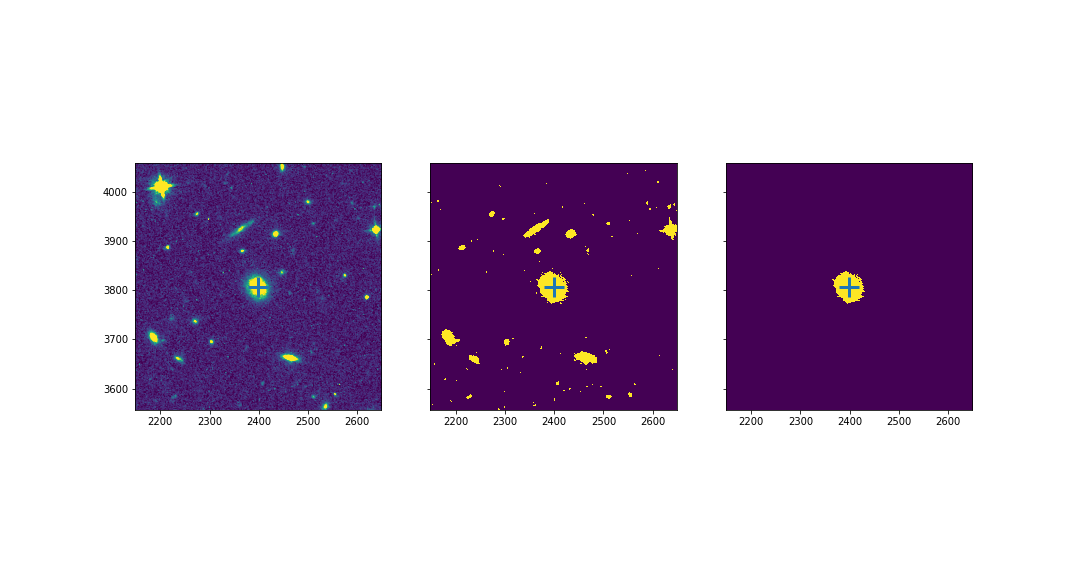

In [13]:
#verifying this^^works above


%matplotlib notebook 

fig, axis = mpl.subplots(1,3,figsize=(15,8),sharex=True,sharey=True)
axis[0].imshow(image_data,vmin = -0.01,vmax = 0.1)
axis[1].imshow(segmap_reversed,vmin=0,vmax=1)
axis[2].imshow(regions,vmin=0, vmax=1)
for ax in axis:
    ax.plot(xc, yc, "+",ms=20,mew=3)
    
    w = 250
    ax.set_xlim(xc-w,xc+w)
    ax.set_ylim(yc-w,yc+w)
 

# TEST: Creating Parameter -- Mask_Name with ONE filter and MULTIPLE detected objects 

In [14]:
#defing inputs
#Main Idea: Mask_name = segmentation_map - mask_map
#                       segmentation_maps = {filter}_check.fits files


#One Filter to start
filters = {"F105W"}

#all detected objects in this filter
detected_objs_file = ascii.read('testPSF_F105W.cat')

### Deciding Seg_map subselection of detections

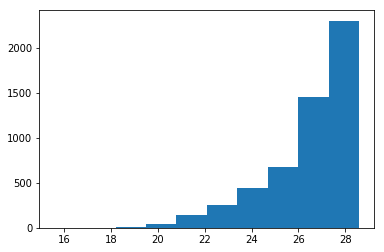

In [15]:
#test for where to put mag cut


%matplotlib inline
mpl.hist(detected_objs_file['MAG_AUTO'])
mpl.show()

In [16]:
#subselecting detections for bright galaxies likely to be part of the cluster

#quick cut based on magnitudes to get brightest BUT theres stars in here!, need further cut
short_detections1 = detected_objs_file#[0:5]
short_detections2 = np.where(short_detections1['MAG_AUTO']<20)
short_detections = short_detections1[short_detections2]
short_detections

NUMBER,MAG_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,,pix2,pix,pix,pix,pix,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
78,16.8101,3.5,3892,2069,687,2069.7656,686.6669,4.74,0.87,15.7178,0.101,0.999,2.589
101,18.2251,3.5,8407,1667,842,1667.4615,842.0389,18.89,39.08,19.0108,0.518,0.914,10.234
336,19.8523,4.31,4561,1545,1218,1545.1018,1218.1646,16.606,57.3,21.059,0.35,0.927,16.468
595,19.0657,3.5,1345,2836,1258,2835.8015,1257.6469,3.863,-14.41,17.9312,0.073,0.981,2.538
685,18.4926,3.5,8632,2023,1761,2022.5,1761.1434,20.62,41.04,20.0029,0.462,0.069,13.512
1719,19.5762,3.5,2371,2039,2057,2039.0488,2056.7207,10.67,-22.55,19.837,0.487,0.88,6.471
1752,17.1738,3.5,3054,3043,2098,3043.8008,2097.4866,4.239,-2.62,15.7596,0.019,0.986,2.297
1872,19.72,3.5,892,905,2091,905.2217,2091.1045,3.613,6.68,18.6888,0.142,0.968,2.562


In [17]:
# seperating stars from galaxies in above list (using psf code tricks)


In [18]:
#INDEX TEST-1


short_detections[10:13]

NUMBER,MAG_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,,pix2,pix,pix,pix,pix,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
3038,19.7487,3.88,2775,2744,2911,2744.4302,2911.8064,12.514,51.37,20.8523,0.309,0.9,11.852
3065,19.4481,3.5,4809,2802,2912,2801.3403,2912.0347,14.243,28.68,20.4566,0.098,0.926,11.852
3187,19.6093,3.5,3679,3402,2972,3401.6521,2972.3645,12.016,-1.45,20.1289,0.134,0.911,9.245


### Creating mask of cluster galaxies

In [19]:
#PARTIAL RUN

#runs for ONE array w/o collecting yet - see NEXT CELL FOR FULL RUN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#this works for now but not sure how to collect each_region so tests in next cell


#defing input parameters for fcn 

#for reference
#detected_objs_file = ascii.read('testPSF_F105W.cat')
#short_detections = detected_objs_file[0:5]

collected_regions = []
#creating cycle to pull values for each detected object
for detection in short_detections:
    #print('this is detection:',detection)
    xc = detection["X_IMAGE"] #in pix                      ###PARAMETER
    print('xc val:',xc)
    yc = detection["Y_IMAGE"] #in pix                      ###PARAMETER
    print('yc val:',yc)
    image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
    image_data = image_file[0].data                         ###PARAMETER
    segmap_file = pyfits.open('F105W_check.fits')
    segmap = segmap_file[0].data+0 #+0 at end to avoid big to little endian problems ###PARAMETER
    pixscale = 0.06                                         ###PARAMETER
    #radius=0.5 ##DEFAULT value for reference               ###PARAMETER
    each_region = select_object_map_connected(xc,yc,image_data,segmap,pixscale)
    print('region shape:',each_region.shape,'region data:', each_region)
    break
''' 
    fig, axis = mpl.subplots(1,3,figsize=(15,8),sharex=True,sharey=True)
    axis[0].imshow(image_data,vmin = -0.01,vmax = 0.1)
    axis[1].imshow(segmap_reversed,vmin=0,vmax=1)
    axis[2].imshow(each_region,vmin=0, vmax=1)
    for ax in axis:
        ax.plot(xc, yc, "+",ms=20,mew=3)

        w = 250
        ax.set_xlim(xc-w,xc+w)
        ax.set_ylim(yc-w,yc+w)
'''


xc val: 2069.7656
yc val: 686.6669
region shape: (4824, 4538) region data: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


' \n    fig, axis = mpl.subplots(1,3,figsize=(15,8),sharex=True,sharey=True)\n    axis[0].imshow(image_data,vmin = -0.01,vmax = 0.1)\n    axis[1].imshow(segmap_reversed,vmin=0,vmax=1)\n    axis[2].imshow(each_region,vmin=0, vmax=1)\n    for ax in axis:\n        ax.plot(xc, yc, "+",ms=20,mew=3)\n\n        w = 250\n        ax.set_xlim(xc-w,xc+w)\n        ax.set_ylim(yc-w,yc+w)\n'

In [20]:
'''  
for arr in each_region:
    for i in arr:
        if i >0:
            print(i) #5426 instances but i expected 3892
'''

'  \nfor arr in each_region:\n    for i in arr:\n        if i >0:\n            print(i) #5426 instances but i expected 3892\n'

In [21]:
#FULL RUN

#testing on a shortened array of length 5 
#- includes detected object #4 which is large and in lower right

#for reference
#detected_objs_file = ascii.read('testPSF_F105W.cat')
#short_detections = detected_objs_file[0:5]

image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
image_data = image_file[0].data #PARAMETER
segmap_file = pyfits.open('F105W_check.fits')
segmap = segmap_file[0].data+0 #PARAMETER


collected_regions = []
#creating cycle to pull values for each detected object
for detection in short_detections:
    xc = detection["X_IMAGE"] #in pix #PARAMETER
    yc = detection["Y_IMAGE"] #in pix #PARAMETER
    #print('yc val:',yc)

    pixscale = 0.06 #PARAMETER
    #radius=0.5 ##DEFAULT value for reference #PARAMETER
    each_region = select_object_map_connected(xc,yc,image_data,segmap,pixscale)
    print('shape each region:',each_region.shape)
    collected_regions.append(each_region)        
    print('SHOULD BE STARTING NEXT DETECTIONS CYCLE')  
collected_regions = np.array(collected_regions)
print('collected_regions: type:',type(collected_regions), 'shape:',collected_regions.shape)    
final_regions = np.sum(collected_regions, axis=0) #COLLECTING ALL OUTPUTS TO ONE MASK
print('shape of final regions:',final_regions.shape)


shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
SHOULD BE STARTING 

In [22]:
#INDEX TEST-2


#tyring to add index's to make images subtract properly
#FULL RUN


#testing on a shortened array of length 5 
#- includes detected object #4 which is large and in lower right

#for reference
#detected_objs_file = ascii.read('testPSF_F105W.cat')
#short_detections = detected_objs_file[0:5]

image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
image_data = image_file[0].data #PARAMETER
segmap_file = pyfits.open('F105W_check.fits')
segmap = segmap_file[0].data+0 #PARAMETER

collected_regions_indextest = []
#creating cycle to pull values for each detected object
for detection in short_detections[9:13]: #[1:3]:#[10:12]:
    xc = detection["X_IMAGE"] #in pix #PARAMETER
    yc = detection["Y_IMAGE"] #in pix #PARAMETER
    #print('yc val:',yc)

    pixscale = 0.06 #PARAMETER
    #radius=0.5 ##DEFAULT value for reference #PARAMETER
    each_region_indextest = select_object_map_connected(xc,yc,image_data,segmap,pixscale)
    print('shape each region:',each_region.shape)
    #collected_regions.append(each_region)      
    
    #TESTING this change
    index = detection['NUMBER']
    print('this is the index value:',index)
    each_region_times_index = index * each_region_indextest
    collected_regions_indextest.append(each_region_times_index)
    #for arr in each_region:
    #    for i in arr:
    #        if i >0:
    #            print('some vals:',i) 
    
    print('SHOULD BE STARTING NEXT DETECTIONS CYCLE')  
    ##break #1
#break #2
collected_regions_indextest = np.array(collected_regions_indextest)
print('collected_regions_indextest: type:',type(collected_regions_indextest), 'shape:',collected_regions_indextest.shape)    
final_regions_indextest = np.sum(collected_regions_indextest, axis=0) #COLLECTING ALL OUTPUTS TO ONE MASK
print('shape of final regions index test:',final_regions_indextest.shape)
#print(final)


shape each region: (4824, 4538)
this is the index value: 2824
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
this is the index value: 3038
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
this is the index value: 3065
SHOULD BE STARTING NEXT DETECTIONS CYCLE
shape each region: (4824, 4538)
this is the index value: 3187
SHOULD BE STARTING NEXT DETECTIONS CYCLE
collected_regions_indextest: type: <class 'numpy.ndarray'> shape: (4, 4824, 4538)
shape of final regions index test: (4824, 4538)


In [23]:
np.shape(collected_regions[11][:])

(4824, 4538)

In [24]:
#INDEX TEST-3


for array in final_regions_indextest:
    for i in array:
        if i !=2824 and i !=3038 and i !=3187 and i !=0:
            print(i) 
#collected_regions[11][0].shape
print('this seems to be adding the 2 indices of 3038+3065=6103 ; but those are only 2 indices of the 4 in the subselection of detections')

6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103


6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103


6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103
6103


### verifying output structure

In [17]:
#takes too much time

#tells me how many pixel values correspond to an object detection, 1=object, 0 =no object


####for array in collected_regions[0]:
    #print('array',array.shape)
    #print(array)
    ####for value in array:
        #print('values better be 0:',value)
        #print('value',value.shape)
        ####if value > 0:
            ####print(value)
        #else:
        #    pass
        #break #1
   # break #2
#break #3

In [18]:
#checking output structures


print('shape of final regions:',final_regions.shape)
print('shape of one collected region:', collected_regions[0].shape)
segmap = segmap_file[0].data
print('shape of segmap:', segmap.shape)
print('shape of segmap_reversed:', segmap_reversed.shape)
image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
image_data = image_file[0].data #PARAMETER
print('shape of image data:',image_data.shape )
#print(segmap_reversed)
cat_file = ascii.read('/data1/rowland/testPSF_F105W.cat')
print('cat file is a table of the data in segmap:',cat_file.info)
#type(cat_file)
#cat_file # 5312 rows, 13 columns
#cat_data = np.array(cat_file[0].data)
#print('shape of cat data:',cat_data.shape)

shape of one collected region: (4824, 4538)
shape of final regions: (4824, 4538)
shape of segmap: (4824, 4538)
shape of segmap_reversed: (4824, 4538)
shape of image data: (4824, 4538)
cat file is a table of the data in segmap: <Table length=5312>
     name      dtype       unit                            description                        
------------- ------- ------------- ----------------------------------------------------------
     MAG_AUTO float64           mag                    Kron-like elliptical aperture magnitude
  KRON_RADIUS float64               Kron apertures in units of A or B                         
ISOAREA_IMAGE   int64          pix2                    Isophotal area above Analysis threshold
  XPEAK_IMAGE   int64           pix                        x-coordinate of the brightest pixel
  YPEAK_IMAGE   int64           pix                        y-coordinate of the brightest pixel
      X_IMAGE float64           pix                                    Object position a

<IPython.core.display.Javascript object>


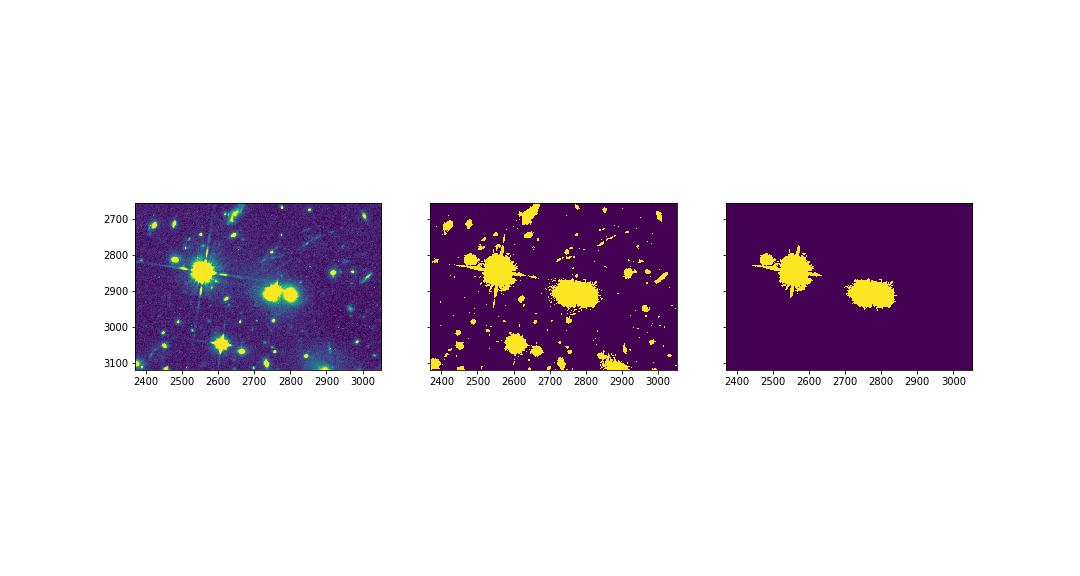

In [93]:
#INDEX TEST-4

%matplotlib notebook 

fig, axis = mpl.subplots(1,3,figsize=(15,8),sharex=True,sharey=True)
axis[0].imshow(image_data,vmin = -0.01,vmax = 0.1)
axis[1].imshow(segmap,vmin=0,vmax=1)
axis[2].imshow(final_regions_indextest,vmin=0, vmax=1)
for ax in axis:
    ax.plot(xc, yc, "+",ms=20,mew=3)
    
    w = 250
    #ax.set_xlim(xc-w,xc+w)
    #ax.set_ylim(yc-w,yc+w)
 

#### need to create intermediate binay image of segmap to do subtraction with binary regions image to truly mask galaxies 

In [29]:
int_segmap_image = np.zeros(np.shape(image_data), dtype = segmap.dtype)
int_segmap_image.shape
int_segmap_image
segmap_forsubtract = int_segmap_image + 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

### doing subtraction to get mask_name of final mask for galfit parameter input

In [21]:
#trying to match array locations and change segmap values to =0 if regions=1
#part1


Mat1 = segmap_reversed
Mat2 = collected_regions[0]

Mat1[np.where(Mat2==1)] = 0
#Mat1[np.where(Mat2==1)[0]] = 0

In [22]:
#trying to match array locations and change segmap values to =0 if regions=1
#part2


get_indexes = lambda Mat1, xs: [i for (y, i) in zip(xs, range(len(xs))) if Mat1 == y]
print(get_indexes('0',Mat1))

/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


[]


In [23]:
#trying to match array locations and change segmap values to =0 if regions=1
#part3


np.shape(Mat1)

(4824, 4538)

In [24]:
#trying to match array locations and change segmap values to =0 if regions=1
#part4


''' 
for array in Mat1:
    print(array)
    for value in array:
        get_indexes = lambda value, xs: [i for (y, i) in zip(xs, range(len(xs))) if value == y]

        if value == 0:
            print(value)
'''

' \nfor array in Mat1:\n    print(array)\n    for value in array:\n        get_indexes = lambda value, xs: [i for (y, i) in zip(xs, range(len(xs))) if value == y]\n\n        if value == 0:\n            print(value)\n'

In [25]:
#testing to see values for potential subtraction to create mask


''' 
for array in segmap_reversed:
    #print('array',array.shape)
    #print(array)
    for value in array:
        #print('values better be 0:',value)
        #print('value',value.shape)
        if value > 0:
            print(value)
        #else:
        #    pass
        #break #1
   # break #2
#break #3
'''

" \nfor array in segmap_reversed:\n    #print('array',array.shape)\n    #print(array)\n    for value in array:\n        #print('values better be 0:',value)\n        #print('value',value.shape)\n        if value > 0:\n            print(value)\n        #else:\n        #    pass\n        #break #1\n   # break #2\n#break #3\n"

# Creating Parameter Mask_name with MULTIPLE filters & detected objects

In [26]:
filters = {"F105W"} #finish this list & fix auto input below, prob need nested for loop
#this needs so much help still

''' 
collected_regions = []
#creating cycle to pull values for each detected object
for detection in short_detections:
    #print('this is detection:',detection)
    xc = detection["X_IMAGE"] #in pix                      ###PARAMETER
    print('xc val:',xc)
    yc = detection["Y_IMAGE"] #in pix                      ###PARAMETER
    print('yc val:',yc)
    image_file = pyfits.open('/data1/rowland/elgordo_%s(filter).fits'%s{filter})
    print('filename:',image_file)
    image_data = image_file[0].data                         ###PARAMETER
    
    #to avoid big to little endian problems gotta do below stuff
    segmap_file = pyfits.open('F105W_check.fits')
    segmap = segmap_file[0].data
    segmap2 = segmap.newbyteorder('<')
    segmap_reversed = np.array(segmap2)                     ###PARAMETER
    pixscale = 0.06                                         ###PARAMETER
    #radius=0.5 ##DEFAULT value for reference               ###PARAMETER
    each_region = select_object_map_connected(xc,yc,image_data,segmap_reversed,pixscale)
    #print(each_region)
    break
'''

' \ncollected_regions = []\n#creating cycle to pull values for each detected object\nfor detection in short_detections:\n    #print(\'this is detection:\',detection)\n    xc = detection["X_IMAGE"] #in pix                      ###PARAMETER\n    print(\'xc val:\',xc)\n    yc = detection["Y_IMAGE"] #in pix                      ###PARAMETER\n    print(\'yc val:\',yc)\n    image_file = pyfits.open(\'/data1/rowland/elgordo_%s(filter).fits\'%s{filter})\n    print(\'filename:\',image_file)\n    image_data = image_file[0].data                         ###PARAMETER\n    \n    #to avoid big to little endian problems gotta do below stuff\n    segmap_file = pyfits.open(\'F105W_check.fits\')\n    segmap = segmap_file[0].data\n    segmap2 = segmap.newbyteorder(\'<\')\n    segmap_reversed = np.array(segmap2)                     ###PARAMETER\n    pixscale = 0.06                                         ###PARAMETER\n    #radius=0.5 ##DEFAULT value for reference               ###PARAMETER\n    each_region

## All Inputs ready to make GalFit input file

In [ ]:
#once all parameters are made can use this to generate an input file for galfit
pixscale = 0.06

#input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None)